<a href="https://colab.research.google.com/github/MaxSannikov2004/samson/blob/main/Similar_Compound_Search_PubChem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Search Similar Compounds Across PubChem Database
Hello Everyone, I am **Dr. Ashfaq Ahmad**. I am going to teach you how will you use RDKit in Jupyter Notebook, and to collect similar compounds to your query compound from PubChem (https://pubchem.ncbi.nlm.nih.gov). This notebook is compiled for teaching and academic research purposes.
PubChem citation: *PubChem in 2021: Nucleic Acids Res.(2021), 49, D1388–D1395*
PubChem database contains chemical molecules and their measured activities against biological assays. It is maintained by the NCBI, which is part of NIH. Currently, It is the world’s largest freely available resource of chemical information and is collected from more than 770 data sources.


In [ ]:
#Install RDKit
!pip install rdkit

We will need to import the required libraries to our space.

In [ ]:
import time
from pathlib import Path
from urllib.parse import quote

from IPython.display import Markdown, Image
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import MolsToGridImage

In [ ]:
HERE = Path(_dh[-1])
DATA = HERE / "data"

# Fetching PubChem CID for the compound of interest

In [11]:
# Get PubChem CID by name
name = "Tamoxifen"

url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()
if "IdentifierList" in response:
    cid = response["IdentifierList"]["CID"][0]
else:
    raise ValueError(f"Could not find matches for compound: {name}")
print(f"PubChem CID for {name} is:\n{cid}")
# NBVAL_CHECK_OUTPUT

HTTPError: 504 Server Error: PUGREST.Timeout for url: https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/Tamoxifen/cids/JSON

# Extract molecular properties for a respective PubChem CID
We extract interesting properties for a compound using PubChem CID, such as molecular weight, pKd, logP, etc. Here, we will search for the molecular weight for Olaparib. You are suggested to edit the script for a particular property, below, I am showing you only **Molecular weight**.

In [12]:
cid="2733526"
# Get mol weight for olaparib
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/property/MolecularWeight/JSON"

r = requests.get(url)
r.raise_for_status()
response = r.json()

if "PropertyTable" in response:
    mol_weight = response["PropertyTable"]["Properties"][0]["MolecularWeight"]
else:
    raise ValueError(f"Could not find matches for PubChem CID: {cid}")
print(f"Molecular weight for {name} is:\n{mol_weight}")
# NBVAL_CHECK_OUTPUT

Molecular weight for Tamoxifen is:
371.5


# Show me the 2D structure of my compound

The 2D structure of Tamoxifen:

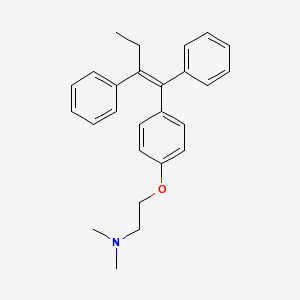

In [14]:
# Get PNG image from PubChem
url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{cid}/PNG"

r = requests.get(url)
r.raise_for_status()

display(Markdown("The 2D structure of Tamoxifen:"))
display(Image(r.content))

# Search of Query compounds for similarity search
The below script will perform the Tanimoto-based similarity search. The 2D PubChem fingerprints will be calculated first. For more information, abount fingerprints, it is highly advised to read (https://jcheminf.biomedcentral.com/articles/10.1186/s13321-016-0163-1).

# Fetching of Query Compound

The structure of Tamoxifen:


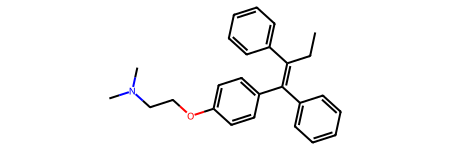

In [15]:
query = "CC/C(=C(\C1=CC=CC=C1)/C2=CC=C(C=C2)OCCN(C)C)/C3=CC=CC=C3"  # Tamoxifen
print("The structure of Tamoxifen:")
Chem.MolFromSmiles(query)

# Creating a job key
The following script will create a job key as per your requiremnts. You can adjust the similarity threshould, and n_recods you expect. In this example we are using threshould value of 75, and n_record value of 10.

In [16]:
def query_pubchem_for_similar_compounds(smiles, threshold=75, n_records=10):
    """
    Query PubChem for similar compounds and return the job key.

    Parameters
    ----------
    smiles : str
        The canonical SMILES string for the given compound.
    threshold : int
        The threshold of similarity, default 75%. In PubChem, the default threshold is 90%.
    n_records : int
        The maximum number of feedback records.

    Returns
    -------
    str
        The job key from the PubChem web service.
    """
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    return key

In [17]:
job_key = query_pubchem_for_similar_compounds(query)

# Download your results

In [18]:
def check_and_download(key, attempts=30):
    """
    Check job status and download PubChem CIDs when the job finished

    Parameters
    ----------
    key : str
        The job key of the PubChem service.
    attempts : int
        The time waiting for the feedback from the PubChem service.

    Returns
    -------
    list
        The PubChem CIDs of similar compounds.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
    print(f"Querying for job {key} at URL {url}...", end="")
    while attempts:
        r = requests.get(url)
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        print(".", end="")
        time.sleep(10)
    else:
        raise ValueError(f"Could not find matches for job key: {key}")
    return cids

In [19]:
similar_cids = check_and_download(job_key)

Querying for job 1806724983535032979 at URL https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/1806724983535032979/cids/JSON...

# Retrieve Canonical_Smiles of the molecules

In [20]:
def smiles_from_pubchem_cids(cids):
    """
    Get the canonical SMILES string from the PubChem CIDs.

    Parameters
    ----------
    cids : list
        A list of PubChem CIDs.

    Returns
    -------
    list
        The canonical SMILES strings of the PubChem CIDs.
    """
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [22]:
similar_smiles = smiles_from_pubchem_cids(similar_cids)

In [32]:
query_results_df = pd.DataFrame({"smiles": similar_smiles, "CIDs": similar_cids})
PandasTools.AddMoleculeColumnToFrame(query_results_df, smilesCol="smiles")
query_results_df.head(10)

,smiles,CIDs,ROMol
0,COC1=CC=C(C=C1)CC=C,8815,<rdkit.Chem.rdchem.Mol object at 0x7831acabf760>
1,CN(C)CCOC(C1=CC=CC=C1)C2=CC=CC=C2,3100,<rdkit.Chem.rdchem.Mol object at 0x7831acabf290>
2,CCC(=C(C1=CC=CC=C1)C2=CC=C(C=C2)OCCN(C)C)C3=CC...,2733526,<rdkit.Chem.rdchem.Mol object at 0x7831acabf840>
3,CC=CC1=CC=C(C=C1)OC,637563,<rdkit.Chem.rdchem.Mol object at 0x7831acabf8b0>
4,CN(C)CCC=C1C2=CC=CC=C2COC3=CC=CC=C31,3158,<rdkit.Chem.rdchem.Mol object at 0x7831acabf920>
5,CC(COC1=CC=CC=C1)NC(C)C(C2=CC=C(C=C2)O)O.Cl,11368,<rdkit.Chem.rdchem.Mol object at 0x7831acabf990>
6,CNCCC(C1=CC=CC=C1)OC2=CC=C(C=C2)C(F)(F)F.Cl,62857,<rdkit.Chem.rdchem.Mol object at 0x7831acabfa00>
7,CN(C)CCC=C1C2=CC=CC=C2COC3=CC=CC=C31,667477,<rdkit.Chem.rdchem.Mol object at 0x7831acabfa70>
8,CCN(CC)CCOC1=CC=C(C=C1)C(=C(C2=CC=CC=C2)Cl)C3=...,1548953,<rdkit.Chem.rdchem.Mol object at 0x7831acabfae0>
9,CCOC1=CC=CC=C1OC(C2CNCCO2)C3=CC=CC=C3,3022645,<rdkit.Chem.rdchem.Mol object at 0x7831acabfbc0>


In [33]:
#Save your data into CSV file
query_results_df.to_csv('similar_olaparib.csv', index=True)

In the above script, query_results_df.head value is set to 6. It means, no matter how many molecules you have requested for in n_records, you will only six of them. So, it is upto you, how many do you want to display here. Change the value and re-run the last script you run.

# Show Results in Image with help of RDKit

In [34]:
def multi_preview_smiles(query_smiles, query_name, similar_molecules_pd):
    """
    Show query and similar compounds in 2D structure representation.

    Parameters
    ----------
    query_smiles : str
        The SMILES string of query compound.
    query_name : str
        The name of query compound.
    similar_molecules_pd : pandas
        The pandas DataFrame which contains the SMILES string and CIDs of similar molecules.

    Returns
    -------
    MolsToGridImage
    """

    legends = [f"PubChem CID: {str(s)}" for s in similar_molecules_pd["CIDs"].tolist()]
    molecules = [Chem.MolFromSmiles(s) for s in similar_molecules_pd["smiles"]]
    query_smiles = Chem.MolFromSmiles(query_smiles)
    return MolsToGridImage(
        [query_smiles] + molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=([query_name] + legends),
        useSVG=True,
    )

The results of querying similar compounds for Tamoxifen:


/usr/local/lib/python3.11/dist-packages/rdkit/Chem/Draw/IPythonConsole.py:343: UserWarning: Truncating the list of molecules to be displayed to 10. Change the maxMols value to display more.
  warnings.warn(


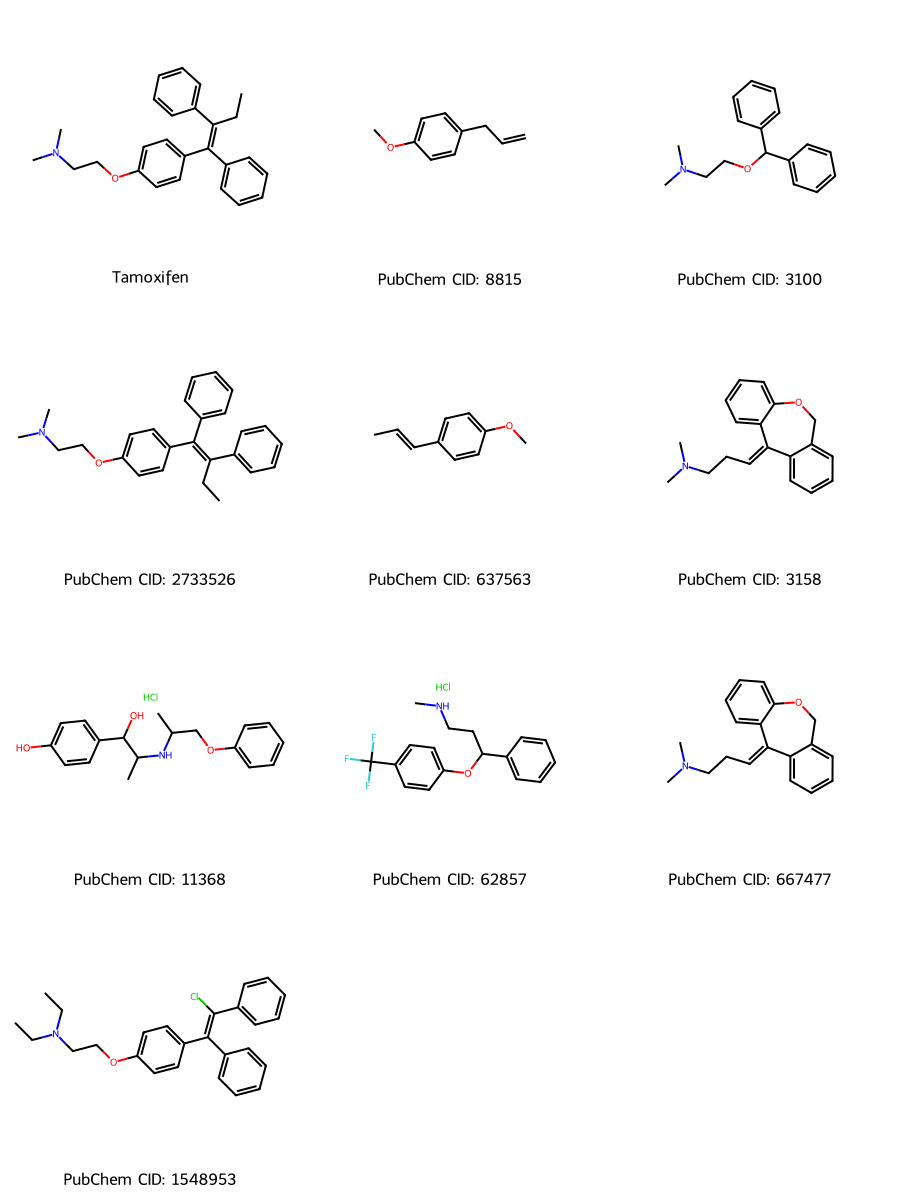

In [35]:
print("The results of querying similar compounds for Tamoxifen:")
img = multi_preview_smiles(query, "Tamoxifen", query_results_df)
img